## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.regularizers import l2

**QUESTION:** Load dataset and display some lines of the csv file.

In [3]:
# Load the dataset
file_path = "ai4i2020.csv"  # Make sure the file is in the same directory or provide the full path
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

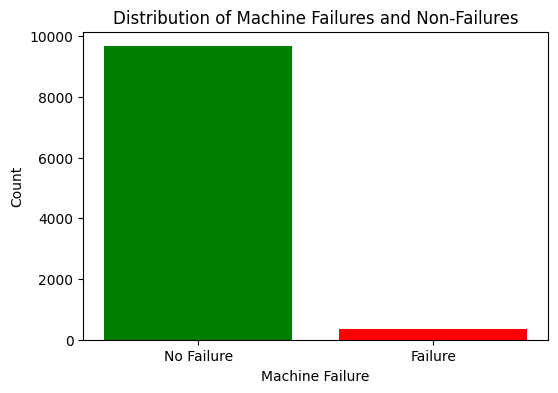

In [ ]:
failure_counts = df['Machine failure'].value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(failure_counts.index, failure_counts.values, color = ['green','red'], tick_label=['No Failure', 'Failure'])
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.title('Distribution of Machine Failures and Non-Failures')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Il y a une forte majorité de machines qui n’ont pas rencontré de panne. Le nombre de machines en bon fonctionnement est largement supérieur à celui des machines en panne. Cela montre un déséquilibre important dans les données, avec beaucoup plus de cas sans panne que de cas avec panne. Ce déséquilibre pourrait avoir un impact sur la performance des modèles de machine learning qui seront entraînés sur ce dataset.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Le déséquilibre des classes, observé dans ce dataset, impactera l’apprentissage du modèle. En effet, lorsque la grande majorité des machines sont en bon état et qu’un très faible nombre présente des pannes, le modèle sera naturellement tenté d’apprendre que la meilleure stratégie consiste simplement à prédire que toutes les machines fonctionnent correctement.Ainsi, le modèle obtiendra une bonne précision , car il aura correctement classé la plupart des machines.

Néanmoins, le vrai objectif d’un modèle de maintenance prédictive est justement de détecter les pannes, idéalement avant qu’elles ne surviennent ou qu’elles ne provoquent des arrêts de production. Or, avec des données aussi déséquilibrées, le modèle risque de passer complètement à côté des cas de panne. Il sera donc très bon pour dire qu’une machine fonctionne, mais très mauvais pour identifier celles qui sont sur le point de tomber en panne.

Ce déséquilibre pose également un problème au niveau de l’évaluation du modèle. Une simple mesure de l'accuracy ne suffira plus pour juger de sa qualité. Il faudra privilégier des métriques plus adaptées comme le recall, qui mesure la capacité à détecter les pannes, ou encore le score F1, qui équilibre précision et rappel.

Enfin, dans un contexte industriel, les conséquences peuvent être graves. Ne pas détecter une panne signifie risquer des arrêts de production imprévus, des pertes financières importantes, voire des accidents ou des dégradations majeures de l’équipement.

Pour atténuer ce problème, il est possible de rééquilibrer les données en augmentant artificiellement le nombre d’exemples de pannes (sur-échantillonnage) ou en réduisant le nombre de machines sans panne (sous-échantillonnage). On peut aussi jouer sur les pondérations des classes lors de l’entraînement, afin d’obliger le modèle à accorder plus d’importance aux pannes.


**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

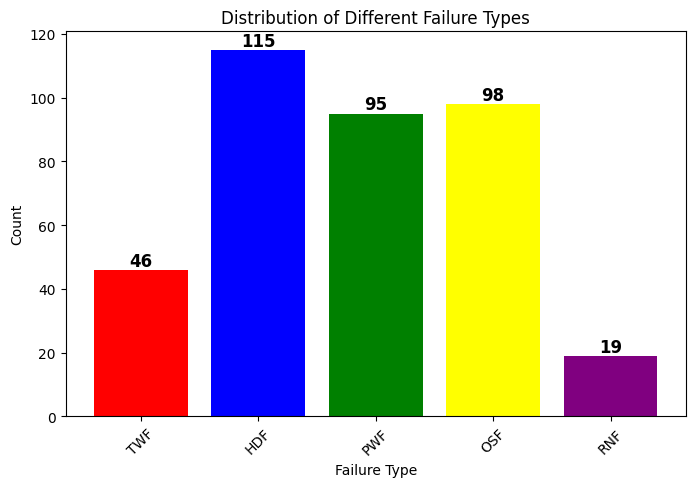

In [ ]:
# Failure types to analyze
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Count occurrences of each failure type
failure_counts = df[failure_types].sum()

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(failure_counts.index, failure_counts.values, color=['red','blue','green','yellow','purple'])

# Add exact values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels and title
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Different Failure Types')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Sur ce graphique, on observe que les pannes ne sont pas réparties de manière uniforme entre les différents types. La panne la plus fréquente est la HDF avec 115 occurrences, suivie par OSF avec 98 occurrences et PWF avec 95 occurrences.

Néanmoins, la panne TWF est moins fréquente avec 46 cas, et la panne la plus rare est la RNF , qui ne compte que 19 occurrences.

Cette répartition montre que certaines causes de pannes, notamment liées à la dissipation thermique et aux surcharges, sont beaucoup plus courantes dans cet environnement industriel que les pannes aléatoires ou l’usure des outils.



**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

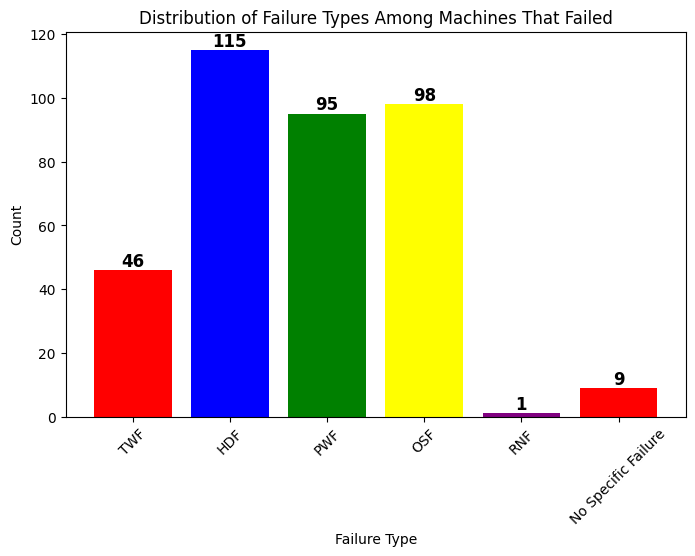

In [ ]:
# Failure types to analyze
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Filter machines that experienced failure
failed_machines = df[df['Machine failure'] == 1]

# Count occurrences of each failure type
failure_counts = failed_machines[failure_types].sum()

# Count machines that failed but had no specific failure type
no_specific_failure_count = (failed_machines[failure_types].sum(axis=1) == 0).sum()

# Add "No Specific Failure" category
failure_counts['No Specific Failure'] = no_specific_failure_count

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(failure_counts.index, failure_counts.values, color=['red','blue','green','yellow','purple'])

# Add exact values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels and title
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Failure Types Among Machines That Failed')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

En comparant ce graphique avec celui de la question précédente, on remarque que les nombres sont similaires, mais il y a une nouvelle catégorie : "No Specific Failure", qui représente les machines qui ont rencontré une défaillance (Machine failure = 1) sans qu’aucun type de panne spécifique (TWF, HDF, PWF, OSF, RNF) ne soit identifié. Cette catégorie comptabilise 9 cas, ce qui montre qu’une petite proportion des machines en échec n’a pas pu être associée à un type de panne précis.

Par ailleurs, la répartition des différents types de pannes (TWF, HDF, PWF, OSF, RNF) reste globalement cohérente avec la répartition observée précédemment. Cela confirme que parmi les machines défaillantes, la majorité des pannes sont dues à des problèmes de dissipation thermique (HDF), de surcharge (OSF) et de pannes d’alimentation (PWF). Les pannes liées à l’usure des outils (TWF) sont moins fréquentes, et les pannes aléatoires (RNF) sont très rares.

Ainsi la présence de la catégorie "No Specific Failure" met en évidence que toutes les pannes ne sont pas systématiquement identifiées ou classifiées, ce qui pourrait indiquer un manque d’information ou un défaut dans le processus de collecte des données. Cela souligne l’importance de s’assurer que les capteurs et les systèmes de diagnostic capturent correctement toutes les informations pertinentes lors d’un incident. Par conséquent, il faudra prendre en compte cette catégorie pour éviter que le modèle ne soit biaisé par l’absence d’information.





**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
print("Noms des colonnes dans le dataset avec leurs types données :\n")
print(df.dtypes)

Noms des colonnes dans le dataset avec leurs types données :

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Pour entraîner le modèle, les entrées seront les caractéristiques mesurées par les capteurs, c'est à dire la température de l’air, la température du processus, la vitesse de rotation, le couple, l’usure de l’outil et le type de machine. Ces variables reflètent les conditions de fonctionnement et permettent d’anticiper les pannes.

La sortie principale sera la colonne Machine failure, qui indique si la machine tombe en panne ou non. En complément, la colonne Failure Type permettra d’identifier la cause de la panne lorsqu’elle survient.

Ce choix est justifié par les analyses précédentes, qui ont montré la répartition des types de pannes et l’importance de bien identifier les causes spécifiques pour être plus précis au niveau des stratégies de maintenance

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [33]:
# Define features (X) and target variable (Y)
X = df.drop(columns=['Product ID','Type','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']).values # All columns except 'Machine failure'
Y = df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF']] # Target column

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display the number of elements in each set
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(8000, 6)
(8000, 5)
(2000, 6)
(2000, 5)


**QUESTION** Code below the model architecture

In [53]:
# Standardize the data (important for neural networks)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Build the Neural Network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input Layer
    keras.layers.Dense(5, activation='softmax')  # On néglige le cas de plusieurs failure
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 773 (3.02 KB)

 Trainable params: 773 (3.02 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.3569 - loss: 26.3966 - val_accuracy: 0.7370 - val_loss: 1.0485
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - accuracy: 0.6027 - loss: 0.8322 - val_accuracy: 0.5080 - val_loss: 0.6627
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - accuracy: 0.5167 - loss: 0.5143 - val_accuracy: 0.2955 - val_loss: 0.3891
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.2736 - loss: 0.5496 - val_accuracy: 0.9835 - val_loss: 0.3467
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.4851 - loss: 0.4657 - val_accuracy: 0.2905 - val_loss: 0.6503
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.4350 - loss: 0.6566 - val_accuracy: 0.0415 - val_loss: 0.4415
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.4946 - loss: 0.4497 - val_accuracy: 0.0120 - val_loss: 0.4501
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - accuracy: 0.3454 - loss: 0.4511 -

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


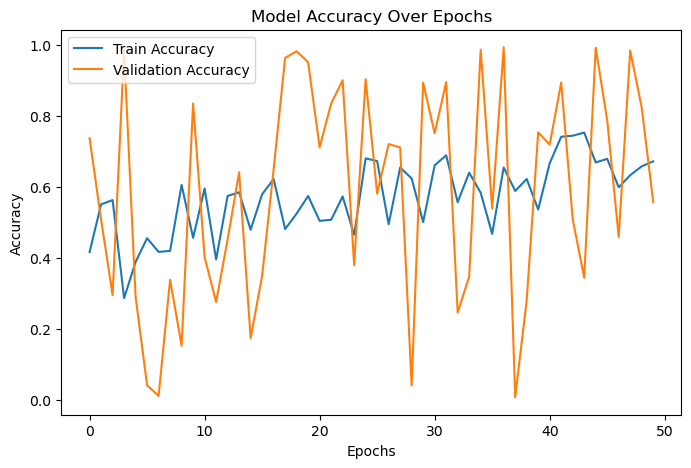

In [55]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate model on test data
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print accuracy and classification report
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





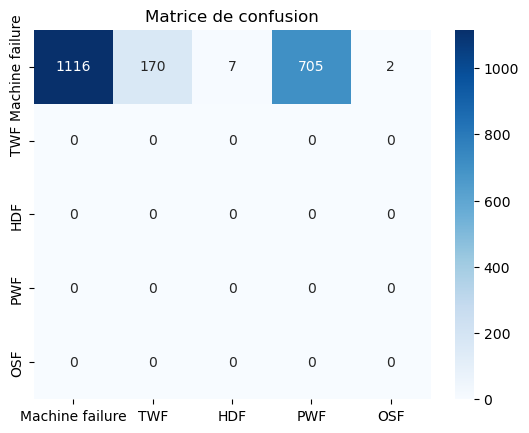

In [57]:
labels = ["No Failure", "TWF", "HDF", "PWF", "OSF"]
# Générer la matrice de confusion unique

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

# Afficher la matrice de confusion sous forme de heatmap
# Affichage de la matrice
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = Y_test.columns,yticklabels=Y_test.columns)
plt.title("Matrice de confusion")
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [106]:
# --- Données
X = df.drop(columns=['Product ID','Type','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
Y = df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF']]  # multilabel

# === Étape 3 : Split train/test ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("=== Taille des ensembles originaux ===")
print(f"X_train : {X_train.shape}")
print(f"Y_train : {Y_train.shape}")
print(f"X_test  : {X_test.shape}")
print(f"Y_test  : {Y_test.shape}")

# === SMOTE multilabel (par colonne) ===
X_resampled = []
Y_resampled = []

for col in Y_train.columns:
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, Y_train[col])
    X_resampled.append(X_res)
    Y_resampled.append(y_res)

X_train_smote = X_resampled[0]  # même X pour chaque SMOTE
Y_train_smote = pd.DataFrame({col: Y_resampled[i] for i, col in enumerate(Y_train.columns)})

# Affichage des tailles après rebalancing
print("\nTaille après rebalancing :")
print(f"X_train_smote : {X_train_smote.shape}")
print(f"Y_train_smote : {Y_train_smote.shape}")

=== Taille des ensembles originaux ===
X_train : (8000, 6)
Y_train : (8000, 5)
X_test  : (2000, 6)
Y_test  : (2000, 5)

Taille après rebalancing :
X_train_smote : (15444, 6)
Y_train_smote : (15930, 5)


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [150]:

model = Sequential([
    Dense(128, input_shape=(X_train_smote.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(Y_train_smote.shape[1], activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='binary_acc'), AUC(name='AUC')]
)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,293 (48.02 KB)

 Trainable params: 11,845 (46.27 KB)

 Non-trainable params: 448 (1.75 KB)

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.5574 - binary_acc: 0.5380 - loss: 0.9437 - val_AUC: 0.0000e+00 - val_binary_acc: 0.2151 - val_loss: 1.1271
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - AUC: 0.7543 - binary_acc: 0.7138 - loss: 0.7089 - val_AUC: 0.0000e+00 - val_binary_acc: 0.4683 - val_loss: 0.8968
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - AUC: 0.8279 - binary_acc: 0.7797 - loss: 0.6085 - val_AUC: 0.0000e+00 - val_binary_acc: 0.6861 - val_loss: 0.6788
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - AUC: 0.8594 - binary_acc: 0.8035 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_binary_acc: 0.8346 - val_loss: 0.4924
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - AUC: 0.8783 - binary_acc: 0.8152 - loss: 0.5220 - val_AUC: 0.0000e+00 - val_binary_acc: 0.8420 - val_loss: 0.4791
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - AUC: 0.8848 - binary_acc: 0.8192 - loss: 0.5096 - val_AUC: 0.0000e+00 - val_binary_acc: 0.9268 - val_l

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


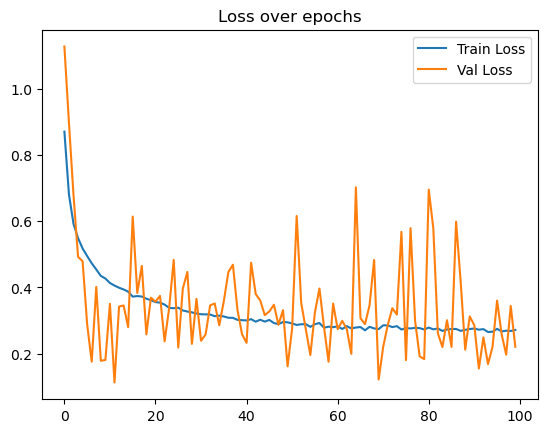

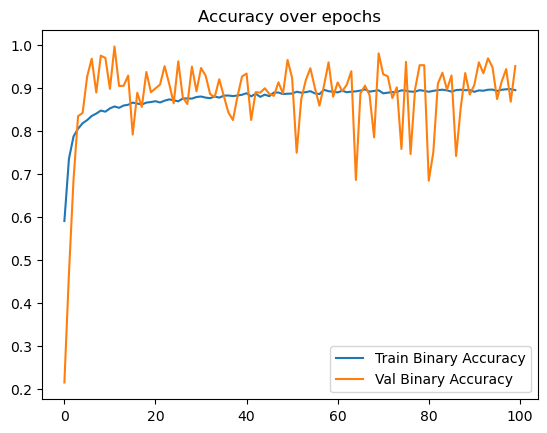

In [152]:
# === Entraînement ===
#early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train_smote, Y_train_smote,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    verbose=1
)

# === Évaluation ===
Y_pred = model.predict(X_test)
Y_pred_bin = (Y_pred > 0.5).astype(int)

print("\n=== Classification Report (par label) ===")
print(classification_report(Y_test, Y_pred_bin, target_names=Y.columns))

# === Affichage courbes loss / accuracy (optionnel) ===
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['binary_acc'], label='Train Binary Accuracy')
plt.plot(history.history['val_binary_acc'], label='Val Binary Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

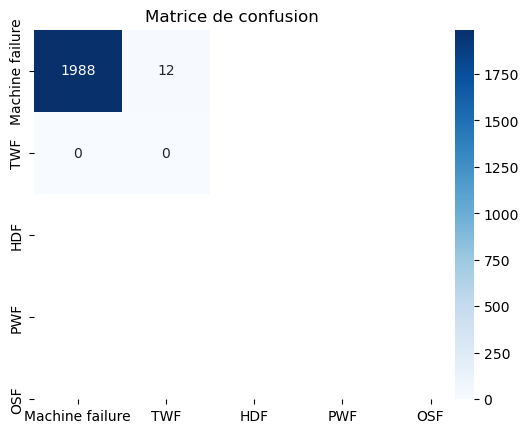

Occurrences dans Y_test:
Machine failure    61
TWF                11
HDF                17
PWF                20
OSF                18
dtype: int64

Occurrences dans Y_pred_bin:
Machine failure    335
TWF                340
HDF                318
PWF                310
OSF                318
dtype: int64


In [181]:
labels = ["No Failure", "TWF", "HDF", "PWF", "OSF"]
# Générer la matrice de confusion unique

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_bin, axis=1))

# Afficher la matrice de confusion sous forme de heatmap
# Affichage de la matrice
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = Y_test.columns,yticklabels=Y_test.columns)
plt.title("Matrice de confusion")
plt.show()

print("Occurrences dans Y_test:")
print(Y_test.sum())

print("\nOccurrences dans Y_pred_bin:")
print(pd.DataFrame(Y_pred_bin, columns=Y.columns).sum())

model.save("modeleAI4I2020.h5")
# Sauvegarder les entrées de validation
np.save("X_val.npy", X_test)

# Sauvegarder les vraies sorties de validation
np.save("Y_val.npy", Y_test)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

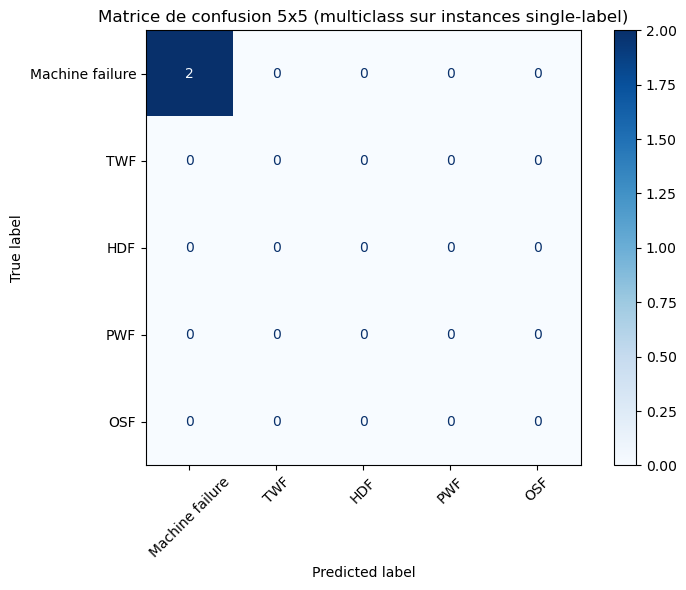

In [175]:
mask = (Y_test.sum(axis=1) == 1)
Y_test_single = Y_test[mask]
Y_pred_bin_single = Y_pred_bin[mask.values]

y_true = np.argmax(Y_test_single.values, axis=1)
y_pred = np.argmax(Y_pred_bin_single, axis=1)


labels = Y.columns.tolist()
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Matrice de confusion 5x5 (multiclass sur instances single-label)")
plt.tight_layout()
plt.show()